This notebook shows how to open and plot the EUMETSAT SEVIRI RSS HRV UK satellite Zarr dataset. We also briefly look at selecting data.

If all you want to do is open the data and plot it, then you probably only need to read down to and including the "Basic selecting and plotting" section.

To run this Notebook, install these packages into your Python environment:

* `zarr`  (for loading the Zarr dataset)
* `xarray`  (for representing n-dimensional labelled arrays)
* `cartopy`  (for drawing geospatial maps)
* `matplotlib`  (for plotting)
* `gcsfs`  (for loading from Google Cloud Storage:  used implicitly by xarray)
* `dask`  (used under the hood by xarray to enable parallel processing of datasets too large to fit into RAM)

In [1]:
import xarray as xr
import cartopy.crs as ccrs  # CRS stands for "coordinate reference system"
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 12)

In [2]:
# TODO: Update this path to the path on Google Cloud Public Datasets when the
# dataset is published on Public Datasets.
SATELLITE_ZARR_PATH = "gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr" 

In [3]:
dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr", 
    chunks="auto",  # Load the data as a Dask array.
)

Let's explain the contents of this Dataset:

The dataset has three dimensions: `time`, `y`, and `x`.

In xarray, each dimension can have an array of "coordinates" which can be thought of as the "labels" for each position in each dimension. For more information, see the [xarray docs](https://xarray.pydata.org/en/stable/user-guide/data-structures.html).

The three main sets of coordinates:

* `time`: The date and time the satellite image was taken (in UTC) rounded to the nearest 5-minute interval.
* `x` and `y`: The geospatial position of each pixel in Geostationary coordinate reference system (with `central_longitude=9.5`). More about coordinate reference systems later...

The imagery is in the `data` variable.

There are two additional coordinates (`x_osgb` and `y_osgb`) which contain are the number of meters from south west corner of Great Britain. In more detail: the `x_osgb` and `y_osgb` values are "eastings" and "northings" in the "OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey" grid reference system (EPSG 27700). See [this WikiPedia page](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid) for more information.

We now have enough information to go ahead and plot some imagery:

## Basic selecting and plotting

Let's see how to select a single datetime and plot it:

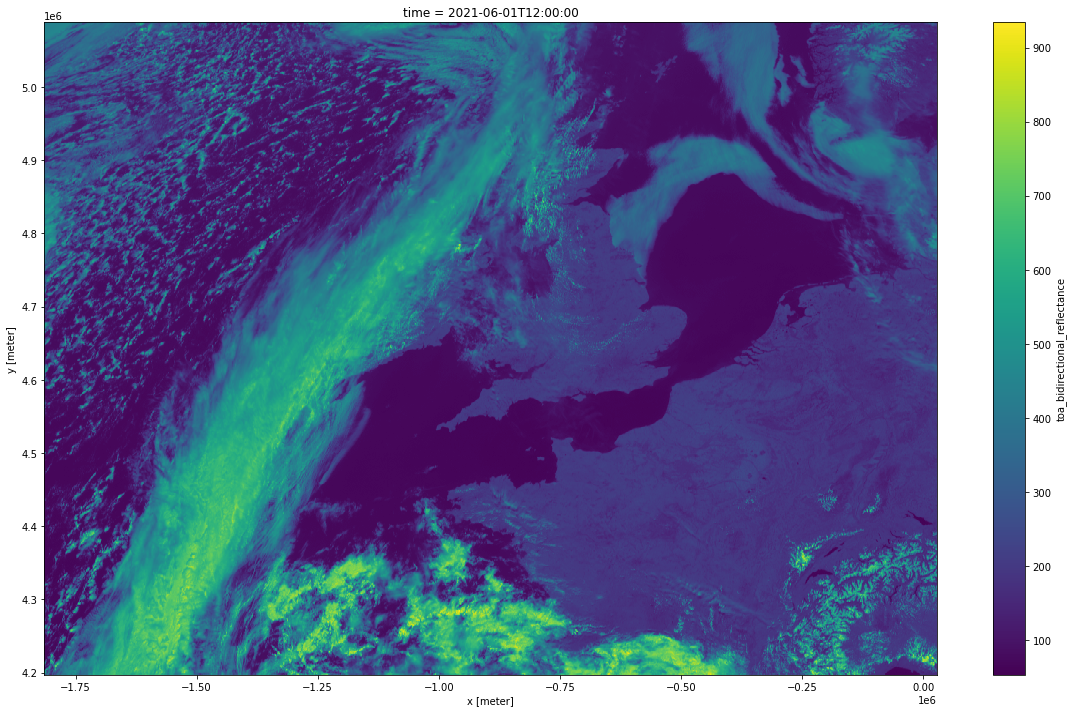

In [4]:
DATETIME_TO_PLOT = "2021-06-01 12:00"
data_array = dataset['data']
data_array.sel(time=DATETIME_TO_PLOT).plot();

### Selecting data

And here's an example of selecting a single hour of data for a small region.

For more information on selecting data, please see [the xarray docs](https://xarray.pydata.org/en/stable/user-guide/indexing.html).

In [5]:
from datetime import datetime
subset = (
    data_array
    # Select a time slice using 'sel' (short for 'select').
    .sel(
        time=slice(
            "2021-06-01 12:00",
            "2021-06-01 12:55",
        )
    )
    # Select a spatial slice using the array indices. 'isel' is short for 'index select'.
    # We could use isel instead of sel to select the date range, if we wanted to select the
    # time range using indices instead of datetime labels.
    .isel(
        x=slice(100, 200), 
        y=slice(400, 600),
    )
)

## Plot (in Geostationary projection) with coastlines super-imposed using Cartopy

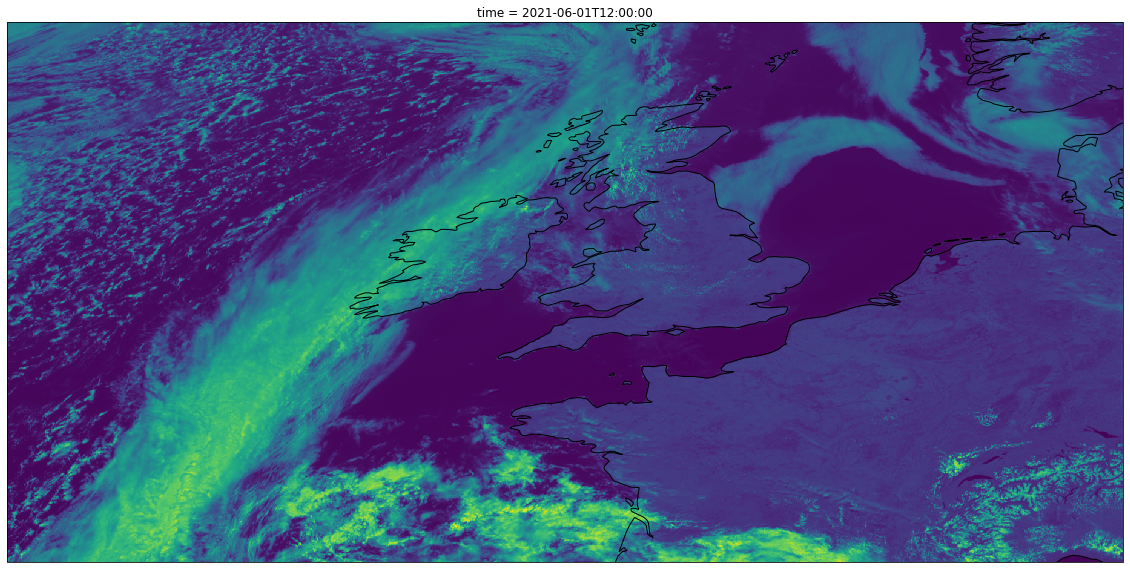

In [6]:
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=9.5))

data_array.sel(time=DATETIME_TO_PLOT).plot.pcolormesh(
    ax=ax, 
    transform=ccrs.Geostationary(central_longitude=9.5), 
    x="x", 
    y="y", 
    add_colorbar=False,
)
ax.coastlines();

## Geospatial projections

You might notice that the map satellite image doesn't look like a "normal" map: The Northern parts of the image look "squished" compared to the South. That's because this image is in the original "Geostationary" projection:  The image looks exactly as you'd expect it to look if you took a photo from 36,000 km away from the Earth! The image above is basically a small crop from the image below of the full Earth disk. The full-disk image below clearly shows why each row of pixels represents more distance on the Earth's surface towards the poles (because the Earth is a sphere!):

![](https://navigator.eumetsat.int/preview/msg-level-1-5.jpg)

(Image take from [EUMETSAT's website](https://navigator.eumetsat.int/product/EO:EUM:DAT:MSG:HRSEVIRI))

We decided not to spatially resample the data because resampling is a lossy process: it introduces artifacts. And, if using a full self-attention machine learning model like [Perceiver IO](https://arxiv.org/abs/2107.14795), then the model can safely consume the raw data (using spatial encoding based on the OSGB coordinates). A convolutional neural network should also be fine with the native, Geospatially-projected data.

There are tools to "spatially reproject" the imagery to another geospatial projection (for example to "warp" the image so that each pixel represents the same distance on the surface of the Earth). For example, see the Python package [pyresample](https://pyresample.readthedocs.io/en/latest/) to resample the satellite imagery. But you probably only have to worry about reprojecting the imagery if you absolutely have to align the data with another spatial dataset. The full specification of the Geospatial projection is in `data_array.attrs['area']` (which is encoded as a YAML string):

In [7]:
print(data_array.attrs['area'])

msg_seviri_rss_1km:
  description: MSG SEVIRI Rapid Scanning Service area definition with 1 km resolution
  projection:
    proj: geos
    lon_0: 9.5
    h: 35785831
    x_0: 0
    y_0: 0
    a: 6378169
    rf: 295.488065897014
    no_defs: null
    type: crs
  shape:
    height: 891
    width: 1843
  area_extent:
    lower_left_xy: [28503.828942775726, 5088183.4998726845]
    upper_right_xy: [-1814743.776023388, 4197063.795030117]
    units: m



In [8]:
# Convert the aread definiton to a Python dictionary:
import yaml
area_dict = yaml.safe_load(data_array.attrs['area'])
area_dict

{'msg_seviri_rss_1km': {'description': 'MSG SEVIRI Rapid Scanning Service area definition with 1 km resolution',
  'projection': {'proj': 'geos',
   'lon_0': 9.5,
   'h': 35785831,
   'x_0': 0,
   'y_0': 0,
   'a': 6378169,
   'rf': 295.488065897014,
   'no_defs': None,
   'type': 'crs'},
  'shape': {'height': 891, 'width': 1843},
  'area_extent': {'lower_left_xy': [28503.828942775726, 5088183.4998726845],
   'upper_right_xy': [-1814743.776023388, 4197063.795030117],
   'units': 'm'}}}

In [9]:
# Load the area definition directly into pyresample:
import pyresample
area_definition = pyresample.area_config.load_area_from_string(data_array.attrs['area'])
area_definition

/home/jack/miniconda3/envs/zarr/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Area ID: msg_seviri_rss_1km
Description: MSG SEVIRI Rapid Scanning Service area definition with 1 km resolution
Projection: {'a': '6378169', 'h': '35785831', 'lon_0': '9.5', 'no_defs': 'None', 'proj': 'geos', 'rf': '295.488065897014', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1843
Number of rows: 891
Area extent: (28503.8289, 5088183.4999, -1814743.776, 4197063.795)